# Third assignment: Network Robustness


# Part 1: Use small graphs to write the code

1. In the first part, you can use some graphs obtained by using the Networkx library or the library of your choice.
2. For each selected graph (max 2 or 3) you can perform different types of attack: turn off nodes at random, turn off the highest degree nodes, those with the highest pagerank, those with the highest betweenness, ...
2. After each removal, compute new measures, for example the size of the giant component or the diameter of the network and then plot these measures with respect to node failures. In case of networks of large size, often for the giant component S/N is plotted, e.g., the ratio between the size of the giant component and the size of the network.
2. Be careful, some of the functions you will use work only for undirected, connected graphs and therefore you need to instrument your code to work on the entire graph first, and then on the several components after the split of the original graph into smaller clusters.

In [1]:
%matplotlib inline
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
from scipy.io import mmread
from scipy import integrate


In [96]:
def remove_random_node(G: nx.Graph) -> nx.Graph:
    """Remove a random node from the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        
    Returns:
        A networkx graph.
    """
    G = get_lcc(G)
    if G.number_of_nodes() > 0:
        # Get a random node from G
        node = random.choice(list(G.nodes))
        # Remove the node from G
        G.remove_node(node)
    # Return the resulting graph
    return G

def remove_highest_degree_node(G: nx.Graph) -> nx.Graph:
    """Remove the node with the highest degree from the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        
    Returns:
        A networkx graph.
    """
    G = get_lcc(G)
    if G.number_of_nodes() > 0:
        # Get the node with the highest degree from G
        node = max(G.degree(), key=lambda x: x[1])[0]
        # Remove the node from G
        G.remove_node(node)
    # Return the resulting graph
    return G

def remove_highest_betweenness_node(G: nx.Graph) -> nx.Graph:
    """Remove the node with the highest betweenness centrality from the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        
    Returns:
        A networkx graph.
    """
    G = get_lcc(G)
    if G.number_of_nodes() > 0:
        # Get the node with the highest betweenness centrality from G
        node = max(nx.betweenness_centrality(G).items(), key=lambda x: x[1])[0]
        # Remove the node from G
        G.remove_node(node)
        # Return the resulting graph
    return G

def remove_highest_pagerank_node(G: nx.Graph) -> nx.Graph:
    """Remove the node with the highest PageRank from the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        
    Returns:
        A networkx graph.
    """
    G = get_lcc(G)
    if G.number_of_nodes() > 0:
        # Get the node with the highest PageRank from G
        node = max(nx.pagerank(G).items(), key=lambda x: x[1])[0]
        # Remove the node from G
        G.remove_node(node)
    # Return the resulting graph
    return G

def remove_highest_closeness_node(G: nx.Graph) -> nx.Graph:
    """Remove the node with the highest closeness centrality from the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        
    Returns:
        A networkx graph.
    """
    G = get_lcc(G)
    if G.number_of_nodes() > 0:
        # Get the node with the highest closeness centrality from G
        node = max(nx.closeness_centrality(G).items(), key=lambda x: x[1])[0]
        # Remove the node from G
        G.remove_node(node)
    # Return the resulting graph
    return G

def get_lcc(G: nx.Graph) -> nx.Graph:
    """Get the largest connected component of the graph G and return the resulting graph.
    
    Args:
        G: A networkx graph.
        
    Returns:
        A networkx graph.
    """
    # Get the largest connected component from G
    largest_comp = max(nx.connected_components(G), key=len) if len(G) > 0 else set()
    # Return the resulting graph
    return nx.Graph(G.subgraph(largest_comp))

def get_lcc_size(G: nx.Graph) -> int:
    """Get the size of the largest connected component of the graph G and return the resulting size.
    
    Args:
        G: A networkx graph.
        
    Returns:
        An integer.
    """
    # Get the largest connected component from G or the empty set if G is empty
    largest_comp = max(nx.connected_components(G), key=len) if len(G) > 0 else set()
    # Return the resulting size
    return len(largest_comp)

def get_diameter(G: nx.Graph) -> int:
    """Get the diameter of the graph G and return the resulting diameter.
    
    Args:
        G: A networkx graph.
        
    Returns:
        An integer.
    """
    if len(G) == 0:
        return 0
    if not nx.is_connected(G):
        G = G.subgraph(max(nx.connected_components(G), key=len))
    return nx.diameter(G) if len(G) > 0 else 0

### First Experiment

Random Graph n=100 p=0,4

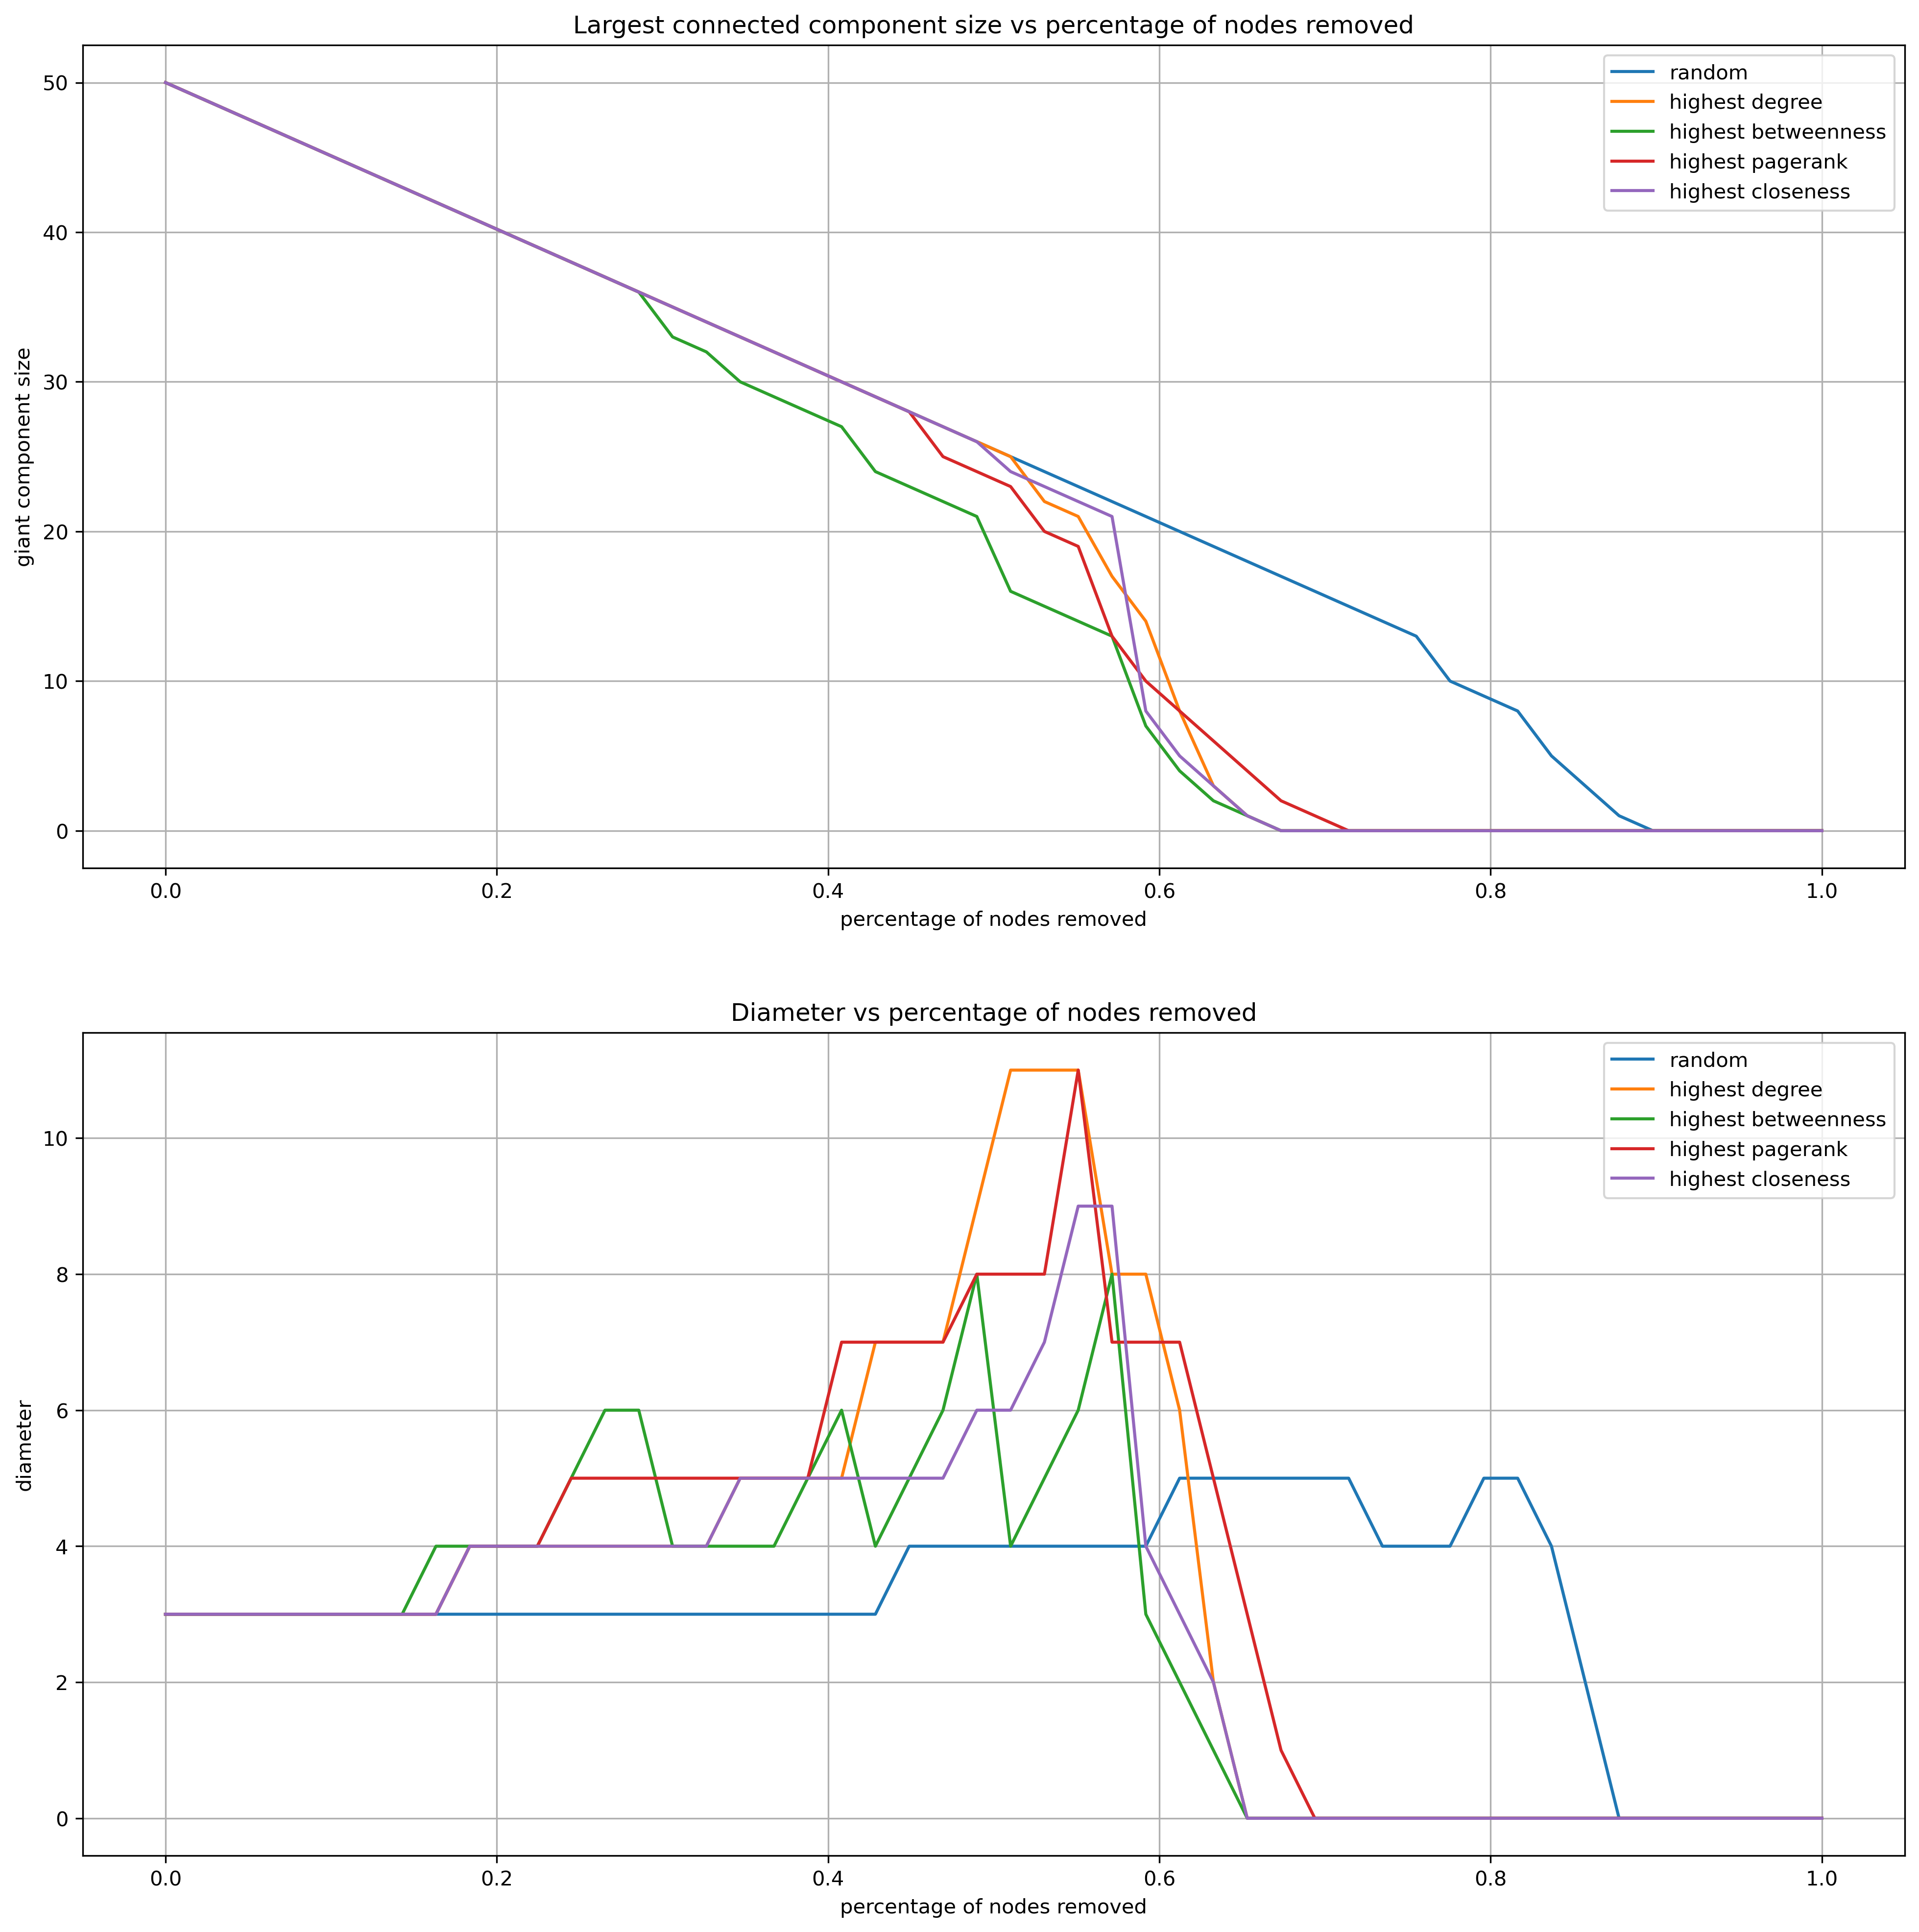

In [107]:
n=50
p=0.2
k=5
G=nx.erdos_renyi_graph(n, p)
# G = nx.watts_strogatz_graph(n, k, p)
# nx.draw(G, with_labels=True)

def attack(G: nx.graph):
    g1 = G.copy()
    g2 = G.copy()
    g3 = G.copy()
    g4 = G.copy()
    g5 = G.copy()

    # giant component size vs random attack
    '''
    x axis: ? should be 0->1
    y axis: giant component size
    '''
    l1 = [0] * (n)
    l2 = [0] * (n)
    l3 = [0] * (n)
    l4 = [0] * (n)
    l5 = [0] * (n)

    d1 = [0] * (n)
    d2 = [0] * (n)
    d3 = [0] * (n)
    d4 = [0] * (n)
    d5 = [0] * (n)

    for i in range(n):
        l1[i] = get_lcc_size(g1)
        l2[i] = get_lcc_size(g2)
        l3[i] = get_lcc_size(g3)
        l4[i] = get_lcc_size(g4)
        l5[i] = get_lcc_size(g5)

        d1[i] = get_diameter(g1)
        d2[i] = get_diameter(g2)
        d3[i] = get_diameter(g3)
        d4[i] = get_diameter(g4)
        d5[i] = get_diameter(g5)

        g1 = remove_random_node(g1)
        g2 = remove_highest_degree_node(g2)
        g3 = remove_highest_betweenness_node(g3)
        g4 = remove_highest_pagerank_node(g4)
        g5 = remove_highest_closeness_node(g5)

    x = np.linspace(0, 1, n)

    plt.figure(figsize=(16,16), dpi=300)
    plt.subplot(2, 1, 1)
    plt.title('Largest connected component size vs percentage of nodes removed')
    plt.plot(x, l1, label='random')
    plt.plot(x, l2, label='highest degree')
    plt.plot(x, l3, label='highest betweenness')
    plt.plot(x, l4, label='highest pagerank')
    plt.plot(x, l5, label='highest closeness')
    plt.xlabel('percentage of nodes removed')
    plt.ylabel('giant component size')
    plt.grid()
    plt.legend()

    plt.subplot(2, 1, 2)
    plt.title('Diameter vs percentage of nodes removed')
    plt.plot(x, d1, label='random')
    plt.plot(x, d2, label='highest degree')
    plt.plot(x, d3, label='highest betweenness')
    plt.plot(x, d4, label='highest pagerank')
    plt.plot(x, d5, label='highest closeness')
    plt.xlabel('percentage of nodes removed')
    plt.ylabel('diameter')
    plt.grid()
    plt.legend()
    plt.show()

attack(G)




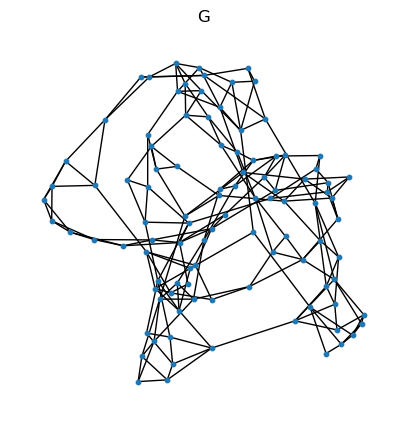

In [101]:
# plot G
plt.figure(figsize=(5,5))
plt.title('G')
nx.draw(G, with_labels=False, node_size=10, width=1)
plt.show()


Analysis Before the Attack

In [4]:
rnd_diameter=[]
rnd_avg_degree=[]
highest_degree_diameter=[]
highest_degree_avg_degree=[]

n=100
p=0.1
G=nx.erdos_renyi_graph(n, p)

In [5]:
def measure(G):
    print(f"Number of nodes: {G.number_of_nodes()}")
    print(f"Number of edges: {G.number_of_edges()}")
   # print(f"Density: {nx.density(G)}")
   # print(f"Transitivity: {nx.transitivity(G)}")
    print(f"Max Degree: {max(dict(G.degree()).values())}")
    print(f"Min Degree: {min(dict(G.degree()).values())}")
    print(f"Average Degree: {np.mean(list(dict(G.degree()).values()))}")
    rnd_avg_degree.append(np.mean(list(dict(G.degree()).values())))
    highest_degree_avg_degree.append(np.mean(list(dict(G.degree()).values())))
    print(f"Number of components:{nx.number_connected_components(G)}")
    print(f"Assortativity: {nx.degree_assortativity_coefficient(G)}")
    betwenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    degree_centrality = nx.degree_centrality(G)
    print(f"Betweenness centrality max:{max(betwenness_centrality.values())}")
    print(f"Closeness centrality max:{max(closeness_centrality.values())}")
    print(f"Degree centrality max:{max(degree_centrality.values())}")

    if(nx.is_connected(G)):
        print("Graph is connected")
        print(f"Diameter: {nx.diameter(G)}")
        highest_degree_diameter.append(nx.diameter(G))
        rnd_diameter.append(nx.diameter(G))
    else:
        print("Graph is not connected")
        G=G.subgraph(max(nx.connected_components(G), key=len))
        highest_degree_diameter.append(nx.diameter(G))
        rnd_diameter.append(nx.diameter(G))


    plt.figure(figsize=(15,5))
    plt.subplot(131)
    plt.title("Betweenness distribution")
    plt.hist(betwenness_centrality.values(), bins=100, log=True)

    plt.subplot(132)
    plt.title("Closeness distribution")
    plt.hist(closeness_centrality.values(), bins=100)

    plt.subplot(133)
    plt.title("Degree centrality distribution")
    plt.hist(degree_centrality.values())
    
    plt.show()
    fig, ax = plt.subplots(figsize=(5,3))

    degree_sequence = sorted((d for n, d in G.degree()), reverse=True)
    dmax = max(degree_sequence)
    plt.bar(*np.unique(degree_sequence, return_counts=True))
    #average degree vicino  alla mediana: 7 -> non è scale free

    fig.tight_layout()
    plt.show()

Number of nodes: 100
Number of edges: 458
Max Degree: 18
Min Degree: 3
Average Degree: 9.16
Number of components:1
Assortativity: -0.04752067101684603
Betweenness centrality max:0.047844737025217625
Closeness centrality max:0.518324607329843
Degree centrality max:0.18181818181818182
Graph is connected
Diameter: 4


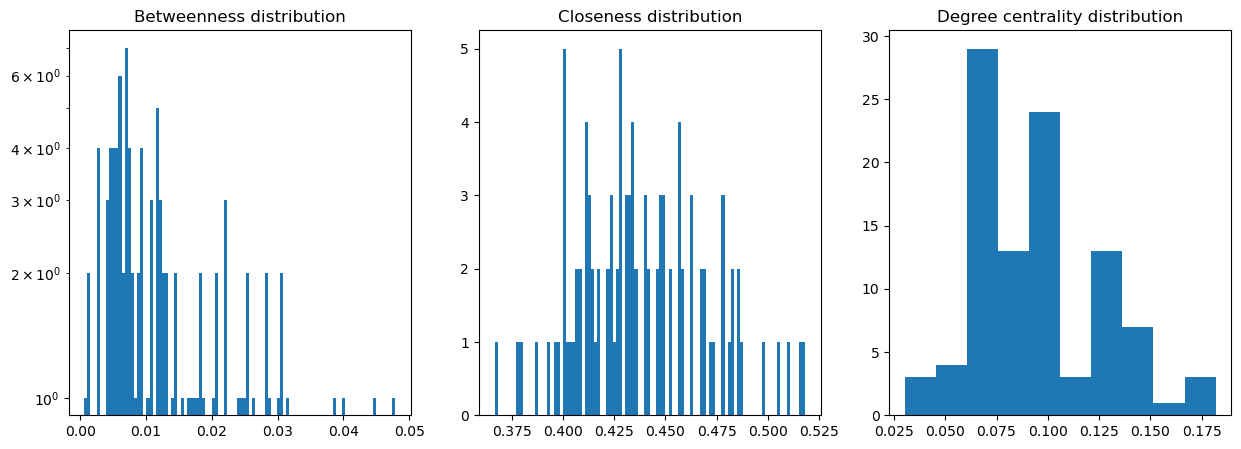

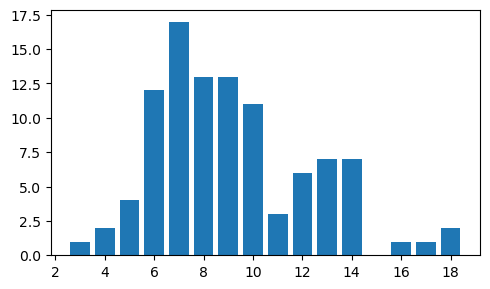

In [6]:
G_rand=G.copy()
measure(G)

Number of nodes: 100
Number of edges: 458
Max Degree: 18
Min Degree: 3
Average Degree: 9.16
Number of components:1
Assortativity: -0.04752067101684603
Betweenness centrality max:0.047844737025217625
Closeness centrality max:0.518324607329843
Degree centrality max:0.18181818181818182
Graph is connected
Diameter: 4


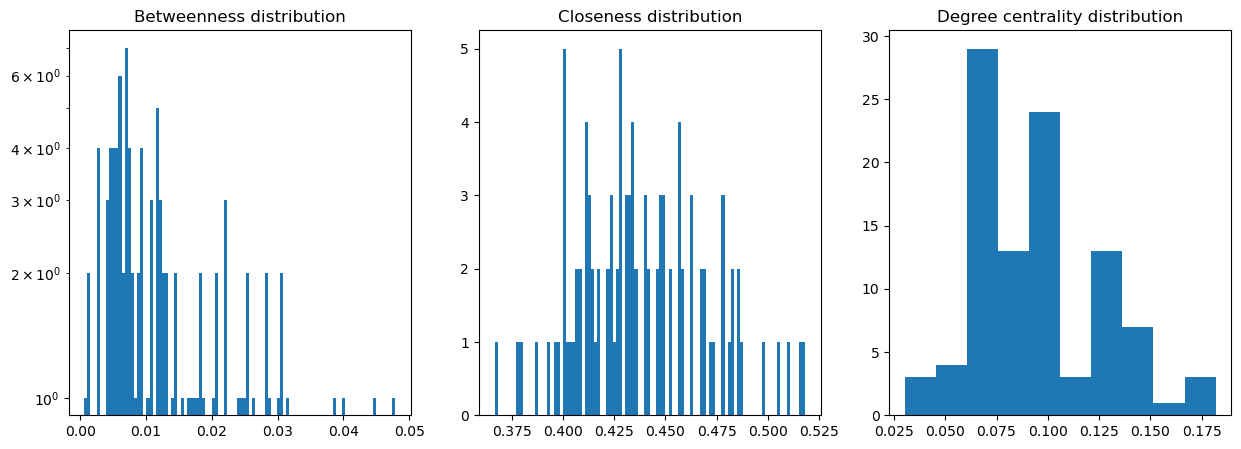

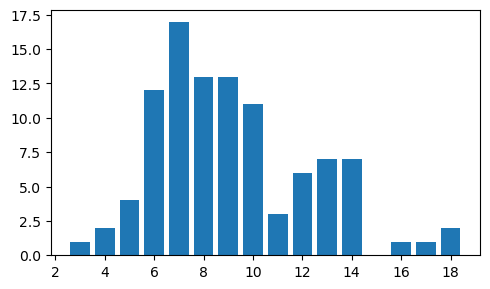

Number of nodes: 90
Number of edges: 378
Max Degree: 17
Min Degree: 2
Average Degree: 8.4
Number of components:1
Assortativity: -0.05874043655810392
Betweenness centrality max:0.053305891226092736
Closeness centrality max:0.5144508670520231
Degree centrality max:0.19101123595505617
Graph is connected
Diameter: 4


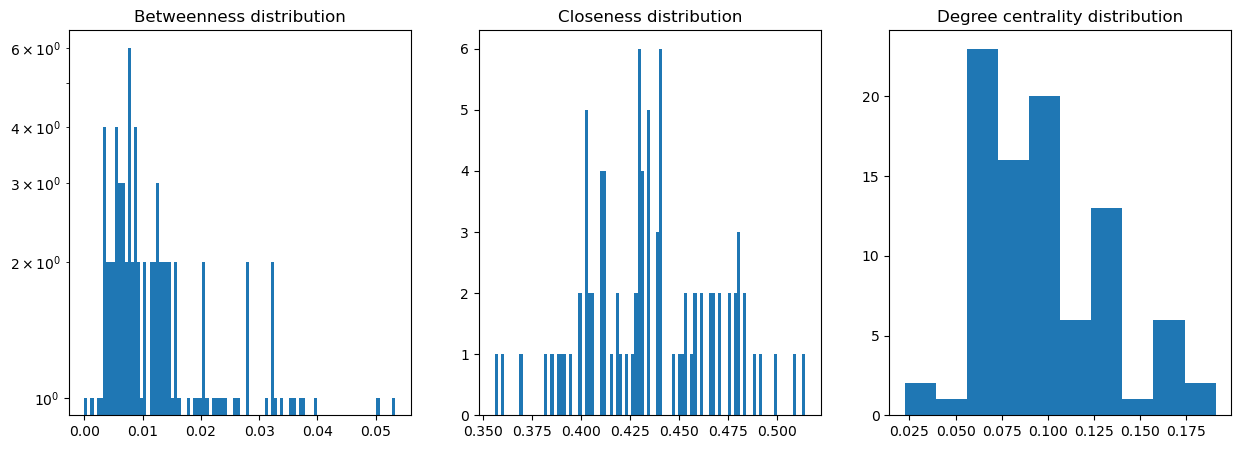

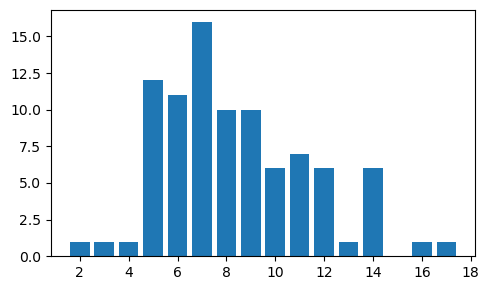

Number of nodes: 72
Number of edges: 254
Max Degree: 16
Min Degree: 2
Average Degree: 7.055555555555555
Number of components:1
Assortativity: -0.10934243781314977
Betweenness centrality max:0.09350684708526129
Closeness centrality max:0.5338345864661654
Degree centrality max:0.22535211267605634
Graph is connected
Diameter: 4


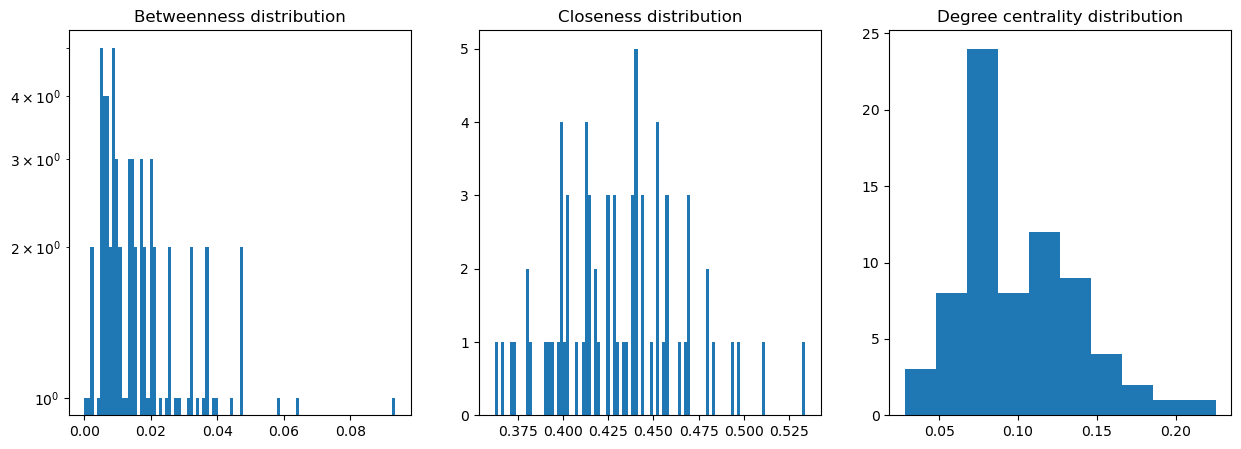

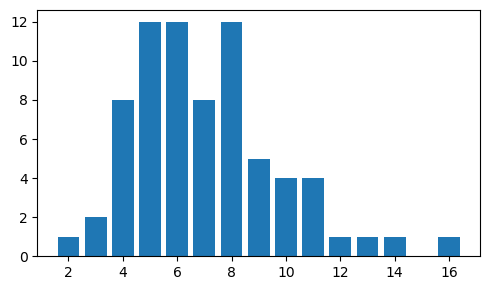

Number of nodes: 50
Number of edges: 120
Max Degree: 12
Min Degree: 0
Average Degree: 4.8
Number of components:2
Assortativity: -0.08780380994088034
Betweenness centrality max:0.15577946005241922
Closeness centrality max:0.5055957867017774
Degree centrality max:0.24489795918367346
Graph is not connected


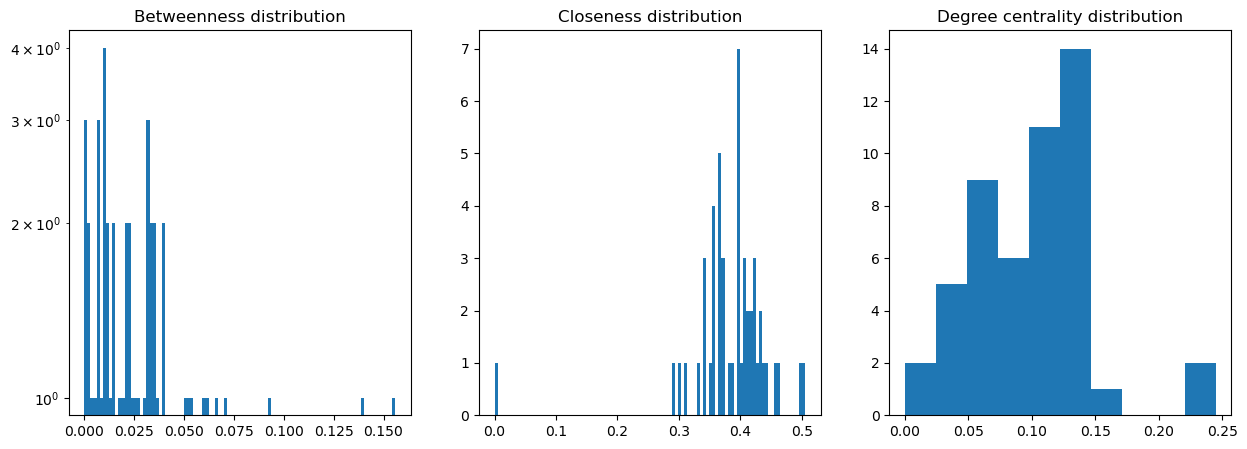

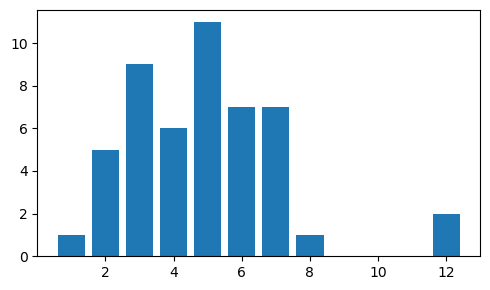

Number of nodes: 30
Number of edges: 41
Max Degree: 8
Min Degree: 0
Average Degree: 2.7333333333333334
Number of components:2
Assortativity: -0.072268647477561
Betweenness centrality max:0.3637931034482758
Closeness centrality max:0.4661117717003568
Degree centrality max:0.27586206896551724
Graph is not connected


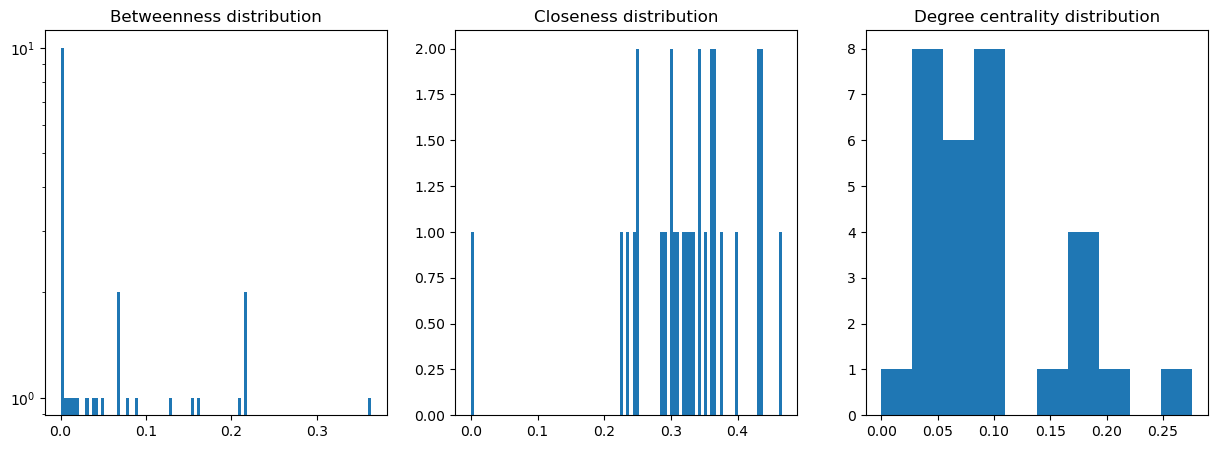

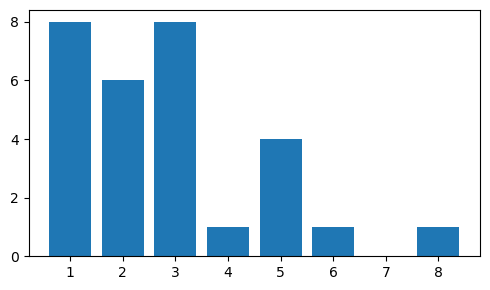

Number of nodes: 15
Number of edges: 13
Max Degree: 4
Min Degree: 0
Average Degree: 1.7333333333333334
Number of components:2
Assortativity: -0.42076502732240406
Betweenness centrality max:0.5824175824175825
Closeness centrality max:0.4023809523809524
Degree centrality max:0.2857142857142857
Graph is not connected


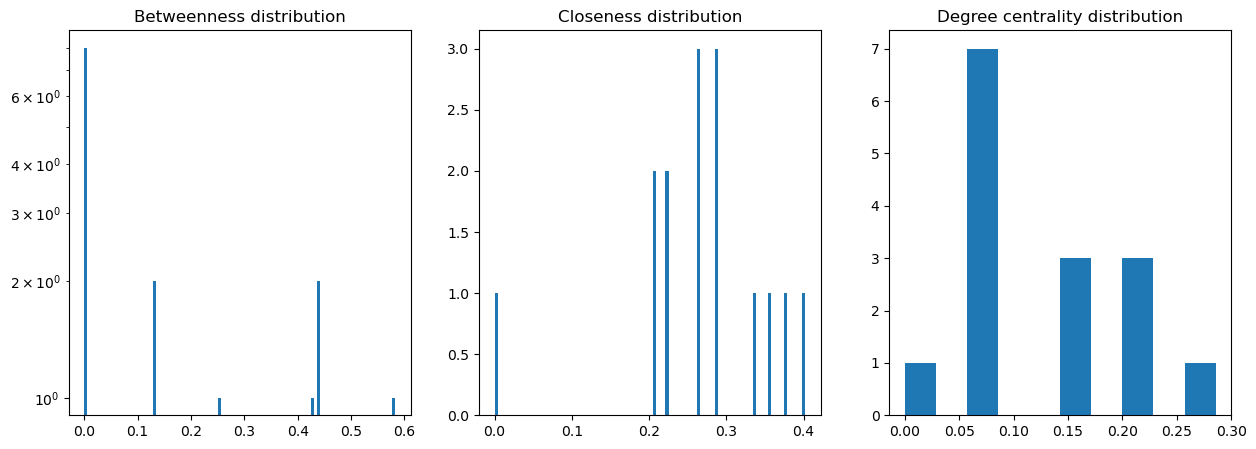

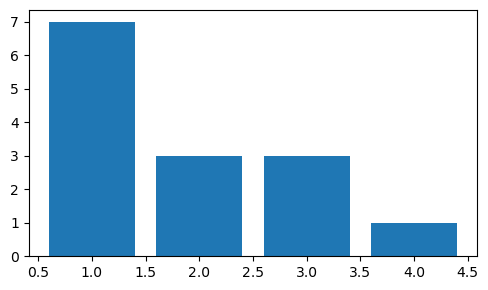

Number of nodes: 6
Number of edges: 2
Max Degree: 2
Min Degree: 0
Average Degree: 0.6666666666666666
Number of components:4
Assortativity: -1.0
Betweenness centrality max:0.1
Closeness centrality max:0.4
Degree centrality max:0.4
Graph is not connected


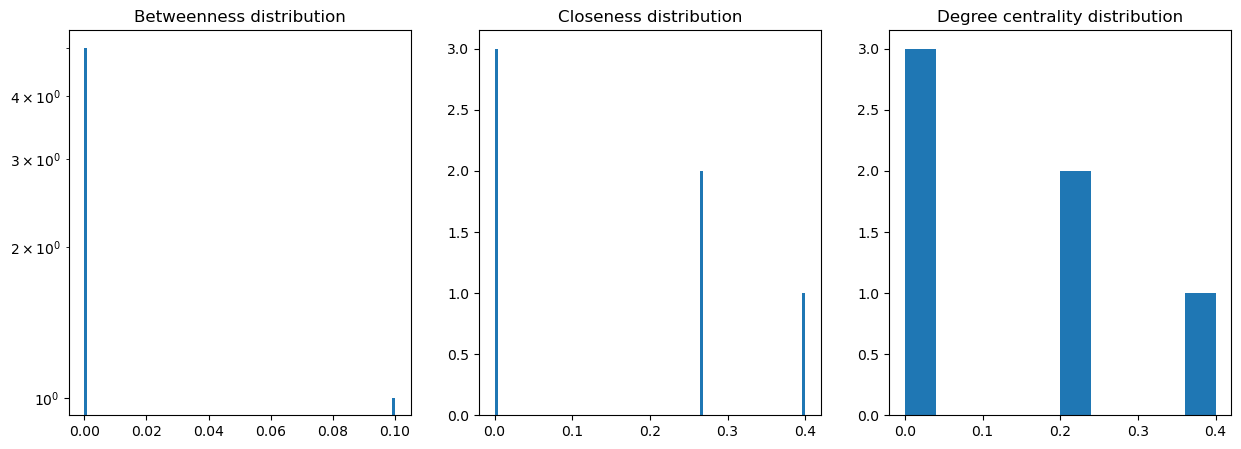

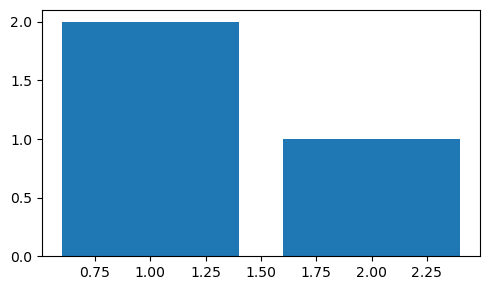

Number of nodes: 2
Number of edges: 0
Max Degree: 0
Min Degree: 0
Average Degree: 0.0
Number of components:2
Assortativity: nan
Betweenness centrality max:0.0
Closeness centrality max:0.0
Degree centrality max:0.0
Graph is not connected


/Users/giorgio/mambaforge/lib/python3.10/site-packages/networkx/algorithms/assortativity/mixing.py:207: RuntimeWarning: invalid value encountered in divide
  a = a / a.sum()


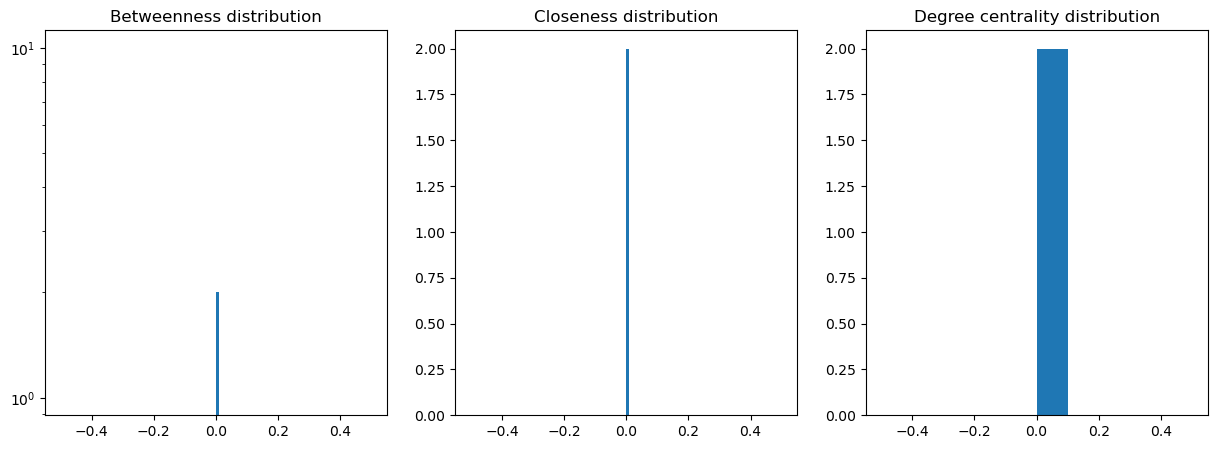

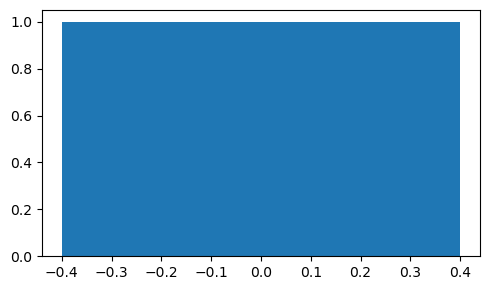

Number of nodes: 0
Number of edges: 0


ValueError: max() arg is an empty sequence

In [7]:
p=0.0001
val_p=[]
while G.number_of_nodes() > 1:
    val_p.append(p)
    # Calculate the number of nodes to remove
    num_nodes = len(G.nodes())
    nodes_to_remove = round(num_nodes * p)

    # Randomly select nodes to remove
    nodes = list(G.nodes())
    nodes_to_remove = random.sample(nodes, nodes_to_remove)

    # Remove the selected nodes from the graph
    G.remove_nodes_from(nodes_to_remove)
    measure(G)
    p+=0.1


Plot distribution of Diameter and Average degree

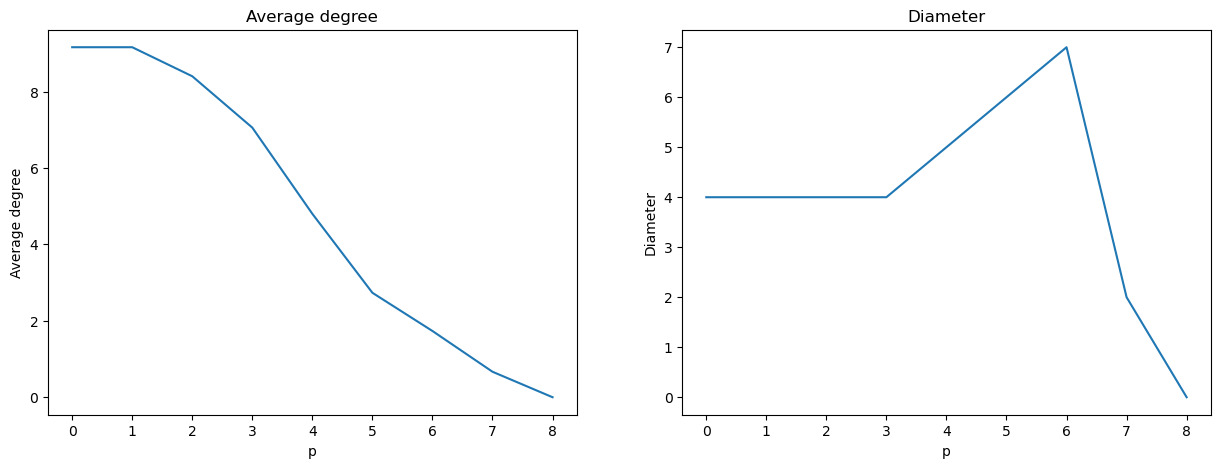

In [8]:
plt.figure(figsize=(15,5))
plt.subplot(121)
plt.title("Average degree")
#x labels = val_p normalizzati

plt.xlabel("p")
plt.ylabel("Average degree")
plt.plot(rnd_avg_degree)

plt.subplot(122)
plt.title("Diameter")
plt.xlabel("p")
plt.ylabel("Diameter")
plt.plot(rnd_diameter)

plt.show()

In [ ]:
print(len(val_p))

## Remove Node with Highest Degree